In [1]:
import pandas as pd
import matplotlib.pyplot as plt # for plotting data

from bs4 import BeautifulSoup
import requests # fetches html content of a website
from urllib.request import HTTPError # for catching timeout for website response
from urllib.request import urlopen
from urllib.request import URLError

import time # for sleep function
from datetime import datetime # for timestamp

import re # for regular expressions
import os
import numpy as np

In [130]:
# B12 js query for capacity
URL = 'https://111.webclimber.de/de/trafficlight?\
callback=WebclimberTrafficlight.insertTrafficlight&\
key=184xNhv6RRU7H2gVg8QFyHCYxym8DKve&\
hid=111&\
container=trafficlightContainer&\
type=&\
area='

In [2]:
def webpage2soup(url, parser="html.parser"):
    headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1)\
     AppleWebKit/537.36 (KHTML, like Gecko)\
     Chrome/41.0.2228.0 Safari/537.36',
    }
    res = requests.get(url, headers=headers)
    res.raise_for_status()

    soup = BeautifulSoup(res.text, parser)
    return soup
            
def online(url="http://google.com"):
    Online = False
    try:
        urlopen(url, timeout=1)
        Online = True
    except URLError as err:
        Online = False
    return Online

def get_current_capacity():
    js_query = 'https://111.webclimber.de/de/trafficlight?\
    callback=WebclimberTrafficlight.insertTrafficlight&\
    key=184xNhv6RRU7H2gVg8QFyHCYxym8DKve&\
    hid=111&\
    container=trafficlightContainer&\
    type=&\
    area='
    
    soup = webpage2soup(js_query)
    percentage_str, num_str = [str(x) for x in soup.div.find_all("div")[-2:]]
    
    
    percentage_template = r"[0-9]+%"
    regex = re.compile(percentage_template)
    m = regex.search(percentage_str)
    percentage = int(m.group()[:-1])

    num_template = r"[0-9]+"
    regex = re.compile(num_template)
    m = regex.search(num_str)
    num = int(m.group())
    return num, percentage

def str2datetime(string, fmt="%H:%M"):
    if type(string) is str:
        return datetime.strptime(string, fmt)
    if type(string) is list:
        return [datetime.strptime(x, fmt) for x in string]

def is_open(timestamp=datetime.now(), return_state=True):
    state = False
    opening_times = {"Mon":["09:30","23:00"], 
                     "Tue":["09:30","23:00"], 
                     "Wed":["08:30","23:00"], 
                     "Thu":["12:30","23:00"], 
                     "Fri":["09:30","23:00"], 
                     "Sat":["10:00","22:00"], 
                     "Sun":["10:00","21:30"]}
    weekdays = list(opening_times.keys())
    
    day = weekdays[timestamp.weekday()]
    opening_time, closing_time = str2datetime(opening_times[day])
    
    if return_state:
        if timestamp.time() > opening_time.time() and timestamp.time() < closing_time.time():
            state = True
        else:
            state = False
        return state
    else:
        # needs to be tested
        opening_time, closing_time = opening_times[day]
        next_day = weekdays[(timestamp.weekday()+1)%7]
        next_opening_time, next_closing_time = str2datetime(opening_times[next_day])
        
        return closing_time, next_opening_time

In [5]:
log = pd.DataFrame(columns=["Free Spots", "Capacity", "Time", "Weekday", "DateTime"])
save2file = "log.csv"

if os.path.isfile(save2file):
    print("logfile already exists, adding new data to existing file.")
    log = pd.read_csv(save2file, sep=";")

while True:
    now = datetime.now() # neccesary?
    if is_open(now):
        if online():
            timestamp = datetime.now()
            timestamp_str = datetime.strftime(timestamp, "%H:%M, %m/%d/%Y")
            weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
            timeofday = datetime.strftime(timestamp, "%H:%M")
            day = weekdays[timestamp.weekday()]

            print("fetching data from B12 API @ " + timestamp_str, end=" --> ")
            payload = get_current_capacity()
            absolute, relative = payload
            update = pd.DataFrame({"Free Spots":[absolute], 
                                   "Capacity":[relative], 
                                   "Time":[timeofday], 
                                   "Weekday":[day], 
                                   "DateTime":[timestamp_str]
                                  })
            print("Free Spots = {0}, Capacity = {1}%.".format(absolute, relative))
            #print("updating logfile")
            log = log.append(update, ignore_index=True, sort=False)
            log.to_csv(save2file, index=False, sep=";")
            time.sleep(60*5)
        else:
            print("Error while trying to reach internet. Waiting 5min then trying again...")
            time.sleep(60*5)
    else:
        now = datetime.now()
        closing_time, next_opening_time = is_open(now, return_state=False)
        print("The B12 is currently closed. Waiting till it opens again @ " 
              + datetime.strftime(next_opening_time, "%H:%M") + "."
             )
        time.sleep((next_opening_time-now).seconds)

The B12 is currently closed. Waiting till it opens again @ 10:00.


KeyboardInterrupt: 

In [3]:
is_open(str2datetime("23:33, 08/28/2020", "%H:%M, %m/%d/%Y"))

False

### Import

In [591]:
data = pd.read_csv("log.csv", sep=";")
str2date = lambda x: datetime.strptime(x, "%H:%M, %m/%d/%Y")
data["DateTime"] = data["DateTime"].apply(str2date)
data["Time"] = data["DateTime"].apply(datetime.time)
data["Date"] = data["DateTime"].apply(datetime.date)
data.head()

,Free Spots,Capacity,Time,Day,DateTime,Date
0,38,46,11:03:00,Fri,2020-08-28 11:03:00,2020-08-28
1,37,48,11:08:00,Fri,2020-08-28 11:08:00,2020-08-28
2,37,48,11:13:00,Fri,2020-08-28 11:13:00,2020-08-28
3,33,54,11:18:00,Fri,2020-08-28 11:18:00,2020-08-28
4,33,54,11:23:00,Fri,2020-08-28 11:23:00,2020-08-28


In [594]:
def plot_summary_stats(data, metrics=["Free Spots", "Capacity"], plotsize=(15,20)):
    n_stats = 4
    fig, ax = plt.subplots(n_stats,len(metrics), figsize=plotsize)
    ax = ax.reshape(n_stats,len(metrics))
    
    x_step = round(data["DateTime"].shape[0]/n_stats)
    weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    
    for idx, metric in enumerate(metrics):
        ax[0,idx].plot(data["DateTime"], data[metric])
        ax[0,idx].set_xticks(data["DateTime"][::x_step])
        ax[0,idx].set_xlabel("time")
        ax[0,idx].set_ylabel(metric)

        for day in weekdays:
            by_day = data[data["Day"] == day]
            by_day = by_day.rename(columns={metric:day})
            by_day.set_index('Time')[day].plot(ax=ax[1,idx], legend=True)
        ax[1,idx].set_xlabel("time")
        ax[1,idx].set_ylabel(metric)

        #data.groupby("Day").mean()[metric].plot(kind="bar", ax=ax[2,idx])
        data.set_index("Time").groupby("Day")[metric].plot(kind="box", ax=ax[2,idx])
        # density plot / rasterplot / heatmap day, time, capacity/free spots
    plt.show()

/home/jnsbck/Applications/anaconda3/envs/default/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/jnsbck/Applications/anaconda3/envs/default/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


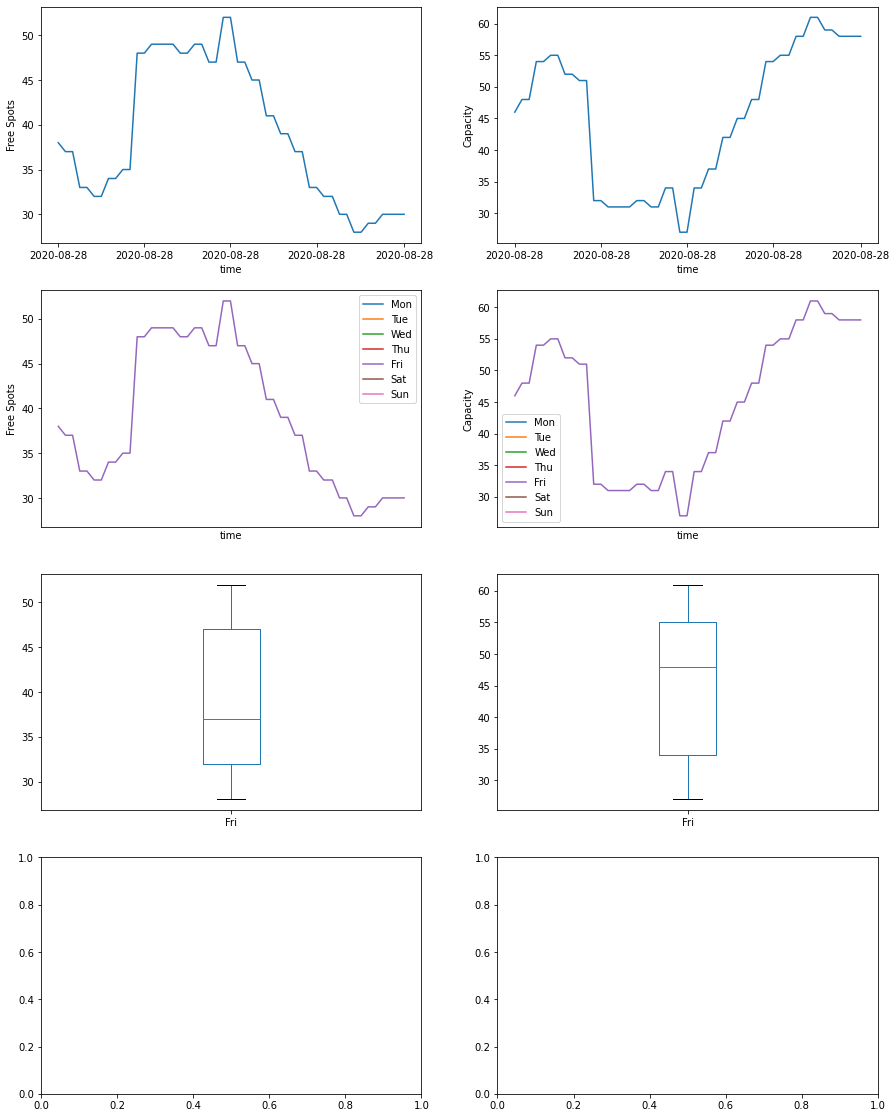

In [595]:
plot_summary_stats(data)

In [555]:
df = data.groupby(['Time','Day'])["Free Spots"].mean().unstack(fill_value=0)
cond = np.logical_and(df.index > datetime.strptime("11:00", "%H:%M").time(),df.index < datetime.strptime("11:15", "%H:%M").time())

In [625]:
for day in weekdays:
    by_day = data[data["Day"] == day]
    by_day = by_day.rename(columns={metric:day})
    by_day.groupby(["Date", "Time"]).mean()[day].plot(ax=ax[1,idx], legend=True)
    print(by_day.groupby(["Time", "Date"]).mean())

Empty DataFrame
Columns: [Free Spots, Mon]
Index: []
Empty DataFrame
Columns: [Free Spots, Tue]
Index: []
Empty DataFrame
Columns: [Free Spots, Wed]
Index: []
Empty DataFrame
Columns: [Free Spots, Thu]
Index: []
                     Free Spots  Fri
Time     Date                       
11:03:00 2020-08-28          38   46
11:08:00 2020-08-28          37   48
11:13:00 2020-08-28          37   48
11:18:00 2020-08-28          33   54
11:23:00 2020-08-28          33   54
11:28:00 2020-08-28          32   55
11:33:00 2020-08-28          32   55
11:38:00 2020-08-28          34   52
11:43:00 2020-08-28          34   52
11:48:00 2020-08-28          35   51
11:53:00 2020-08-28          35   51
11:58:00 2020-08-28          48   32
12:03:00 2020-08-28          48   32
12:08:00 2020-08-28          49   31
12:13:00 2020-08-28          49   31
12:18:00 2020-08-28          49   31
12:23:00 2020-08-28          49   31
12:28:00 2020-08-28          48   32
12:33:00 2020-08-28          48   32
12:38:00 20

In [ ]:
pd.DataFrame({"Test":[1,1],"Test1":[1,1],"Test2":[1,1]}).groupby("Test").mean

In [ ]:
pd.DataFrame().groupby().mean